![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/legal-nlp/90.2.Legal_Visual_NER_Position_Finder.ipynb)

## Colab Setup

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
!pip install -q johnsnowlabs

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [ ]:
from johnsnowlabs import *

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.install(refresh_install=True, visual=True)

In [12]:
import pandas as pd
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F
from sparkocr.utils import display_image, display_pdf
from sparkocr.transformers import *

In [1]:
from johnsnowlabs import nlp, legal, visual
# Automatically load license data and start a session with all jars user has access to
spark = nlp.start(visual=True)

spark

📋 Loading license number 0 from /root/.johnsnowlabs/licenses/license_number_0_for_Spark-Healthcare_Spark-OCR.json
👌 Launched cpu optimized session with with: 🚀Spark-NLP==4.4.1, 💊Spark-Healthcare==4.4.3, 🕶Spark-OCR==4.4.2, running on ⚡ PySpark==3.1.2


## Define Visual NLP transformers and pipeline

In [2]:
pdf_to_text = visual.PdfToText() \
    .setInputCol("content") \
    .setOutputCol("text") \
    .setSplitPage(True) \
    .setStoreSplittedPdf(True) \
    .setExtractCoordinates(True)

position_finder = visual.PositionFinder() \
    .setInputCols("merged_ner_chunks") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setPadding(1)

draw = visual.PdfDrawRegions() \
    .setInputRegionsCol("coordinates") \
    .setOutputCol("pdf_with_regions") \
    .setInputCol("content") \
    .setLineWidth(1)

pipeline = nlp.Pipeline(stages=[
    pdf_to_text,
    position_finder,
    draw 
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)

In [3]:
model.stages

[PdfToText_5186de62c192,
 PositionFinder_fe427676acb9,
 PdfDrawRegions_e0487cd6b197]

## Add Pretrained Pipeline to Visual NLP Pipeline
We will use `legpipe_ner_contract_doc_parties_alias_former` pretrained pipeline to extract entities. For this, we will add pretrained pipeline stages to Visual NLP model stages.

In [4]:
legal_pipeline = nlp.PretrainedPipeline("legpipe_ner_contract_doc_parties_alias_former", "en", "legal/models")
legal_pipeline.model.stages

legpipe_ner_contract_doc_parties_alias_former download started this may take some time.
Approx size to download 891.1 MB
[OK!]


[DocumentAssembler_0e632b91ca6c,
 SentenceDetector_c40687904fc8,
 REGEX_TOKENIZER_8332959a2e46,
 CONTEXTUAL-PARSER_88dab185c582,
 CONTEXTUAL-PARSER_88dab185c582,
 ROBERTA_EMBEDDINGS_b915dff90901,
 LegalNerModel_2581d15a167e,
 NER_CONVERTER_6f30df4468c1,
 ZeroShotRobertaNer_5d06c0297d21,
 NER_CONVERTER_976a5958295a,
 MERGE_70816fd44414]

In [5]:
for i in range(len(legal_pipeline.model.stages)):
  model.stages.insert(i+1, legal_pipeline.model.stages[i])

In [7]:
model.stages

[PdfToText_5186de62c192,
 DocumentAssembler_0e632b91ca6c,
 SentenceDetector_c40687904fc8,
 REGEX_TOKENIZER_8332959a2e46,
 CONTEXTUAL-PARSER_88dab185c582,
 CONTEXTUAL-PARSER_88dab185c582,
 ROBERTA_EMBEDDINGS_b915dff90901,
 LegalNerModel_2581d15a167e,
 NER_CONVERTER_6f30df4468c1,
 ZeroShotRobertaNer_5d06c0297d21,
 NER_CONVERTER_976a5958295a,
 MERGE_70816fd44414,
 PositionFinder_fe427676acb9,
 PdfDrawRegions_e0487cd6b197]

## Read PDF document as binary file

In [ ]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/legal-nlp/data/solution_accelerator_esg_and_rr/agreement_page.pdf


    Image #0:
    Origin: file:/content/pages-1.pdf
    Resolution: 300 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


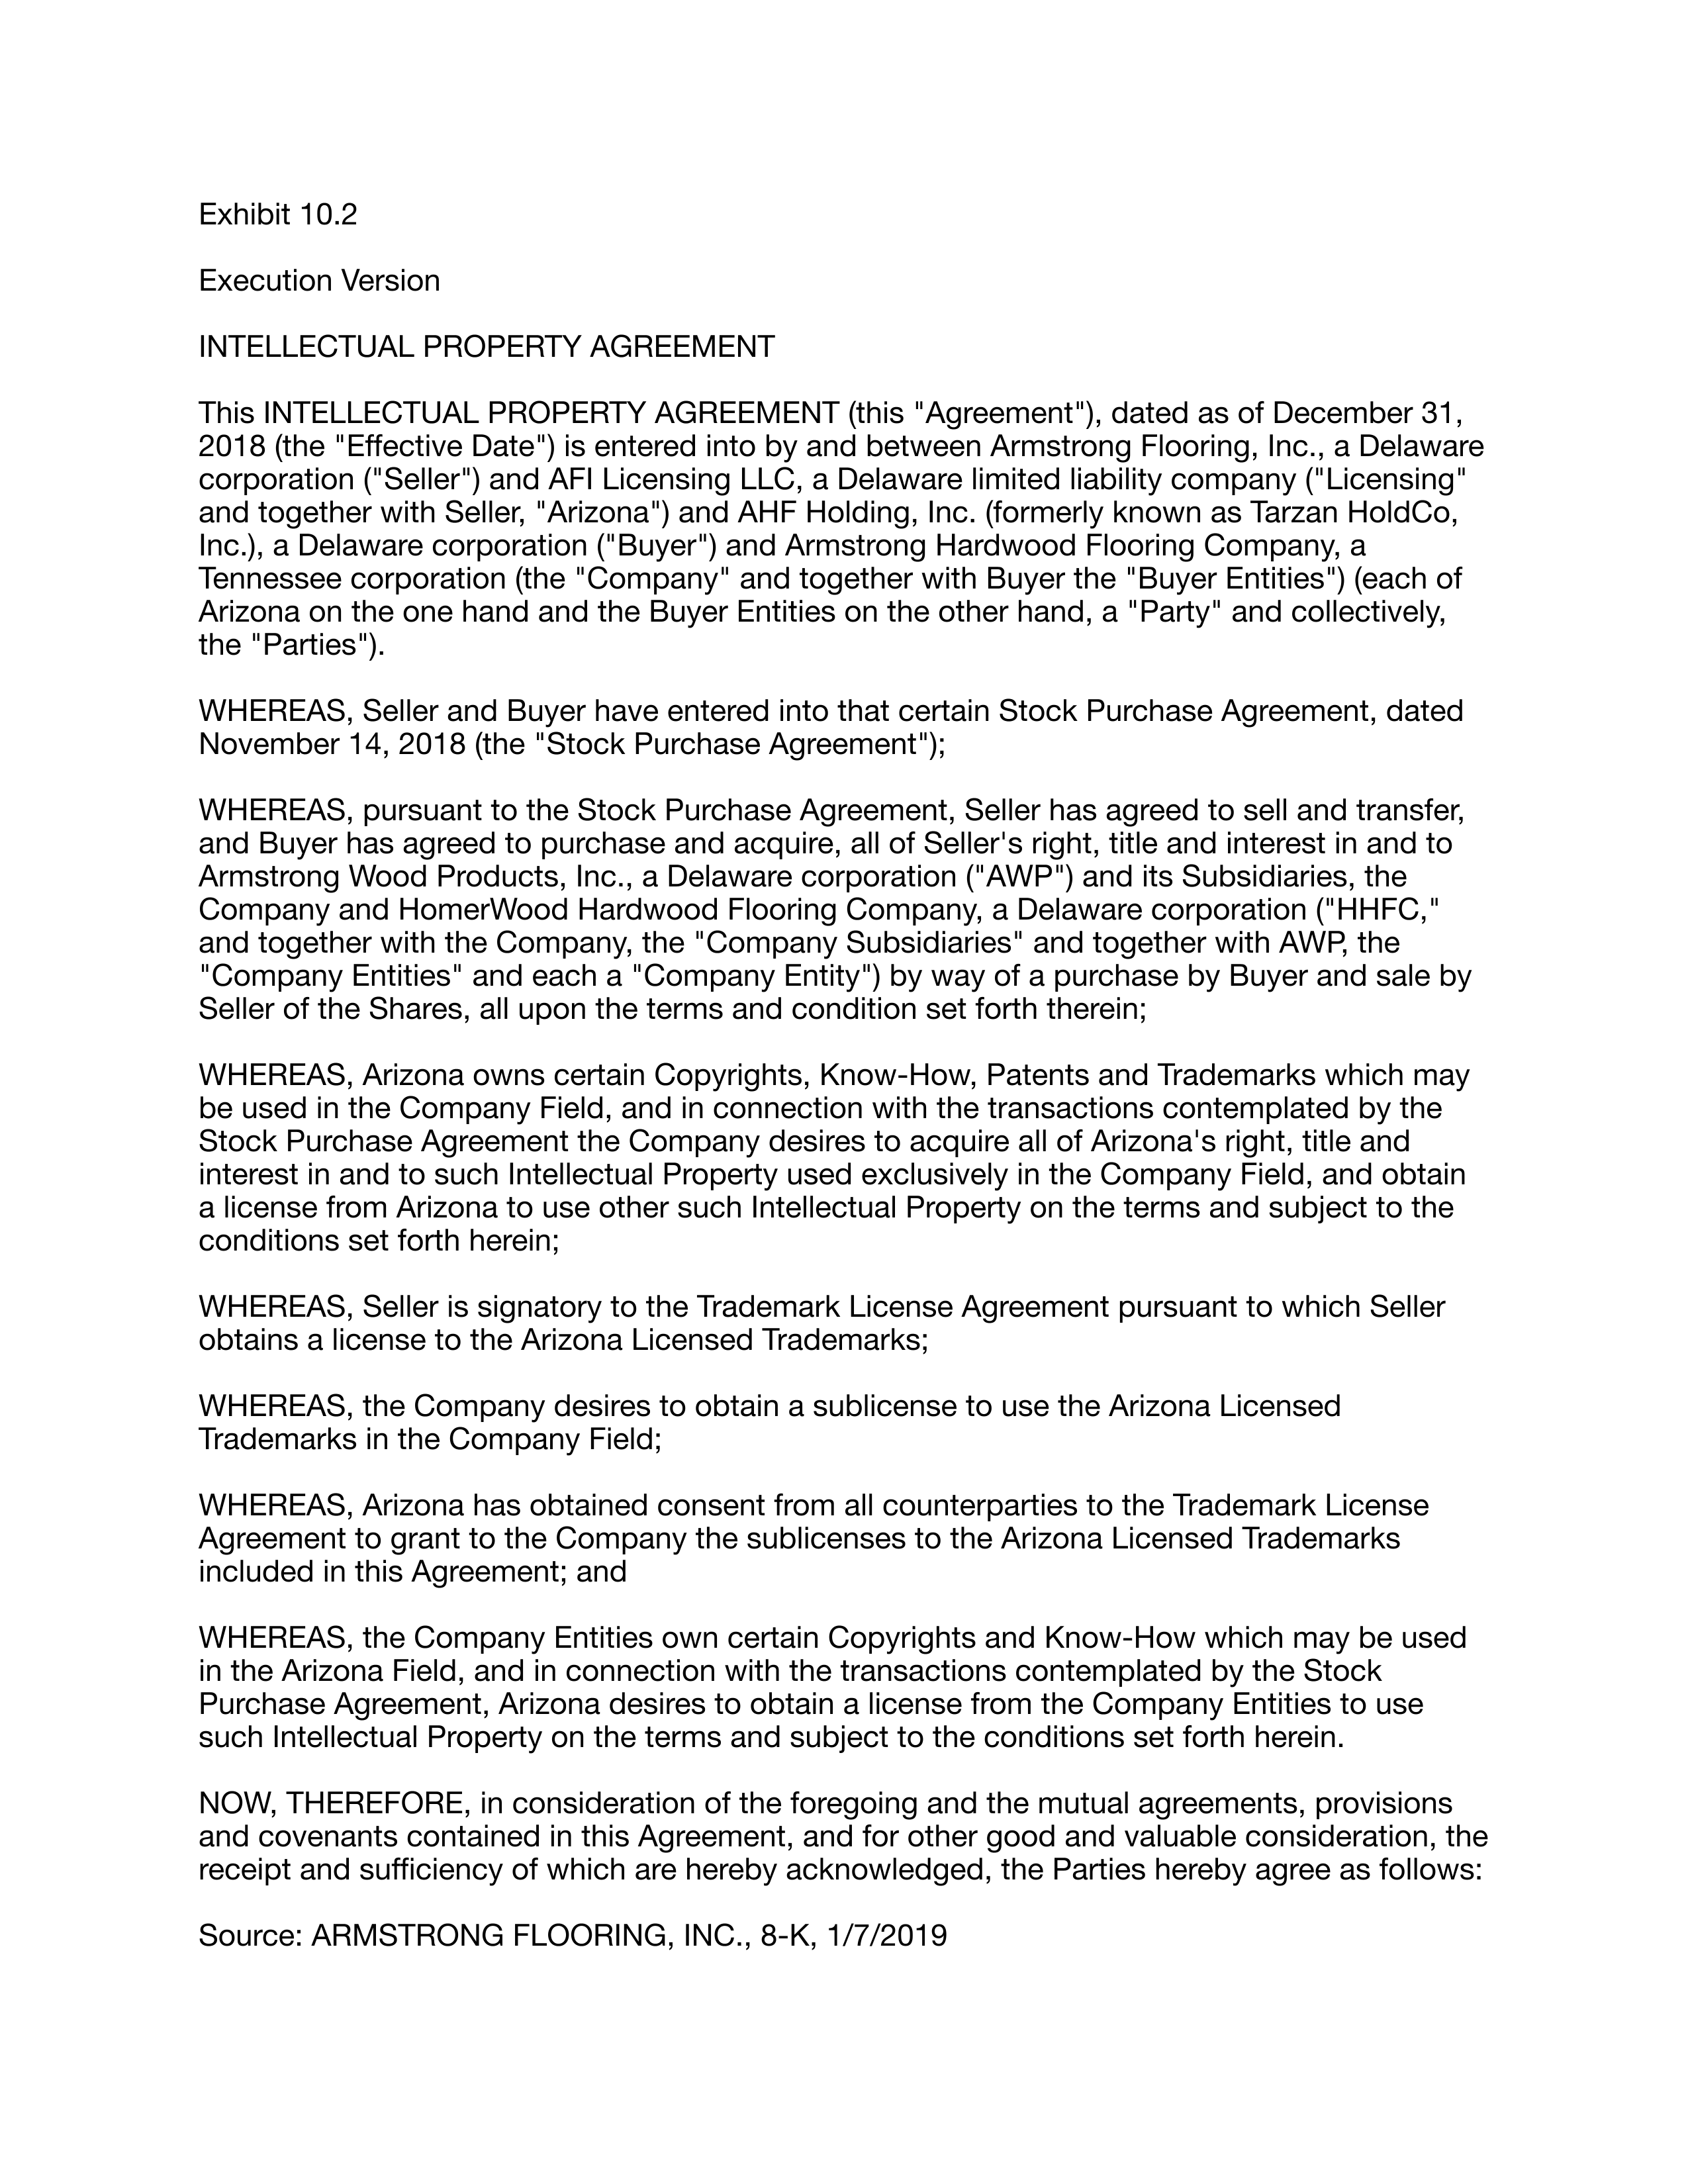

In [14]:
pdf_path = './agreement_page.pdf'

pdf_example_df = spark.read.format("binaryFile").load(pdf_path).cache()

visual.display_pdf(pdf_example_df)

In [15]:
result = model.transform(pdf_example_df).cache()

## Display results

In [16]:
result.select("merged_ner_chunks", "coordinates").show()

+--------------------+--------------------+
|   merged_ner_chunks|         coordinates|
+--------------------+--------------------+
|[{chunk, 33, 63, ...|[{0, 0, 72.0, 120...|
+--------------------+--------------------+



## Store results to pdf file

In [17]:
pdf = result.select("pdf_with_regions").head().pdf_with_regions
pdfFile = open("result.pdf", "wb")
pdfFile.write(pdf)

20484

## Convert pdf to image and display 


    Image #0:
    Origin: file:/content/pages-1.pdf
    Resolution: 300 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


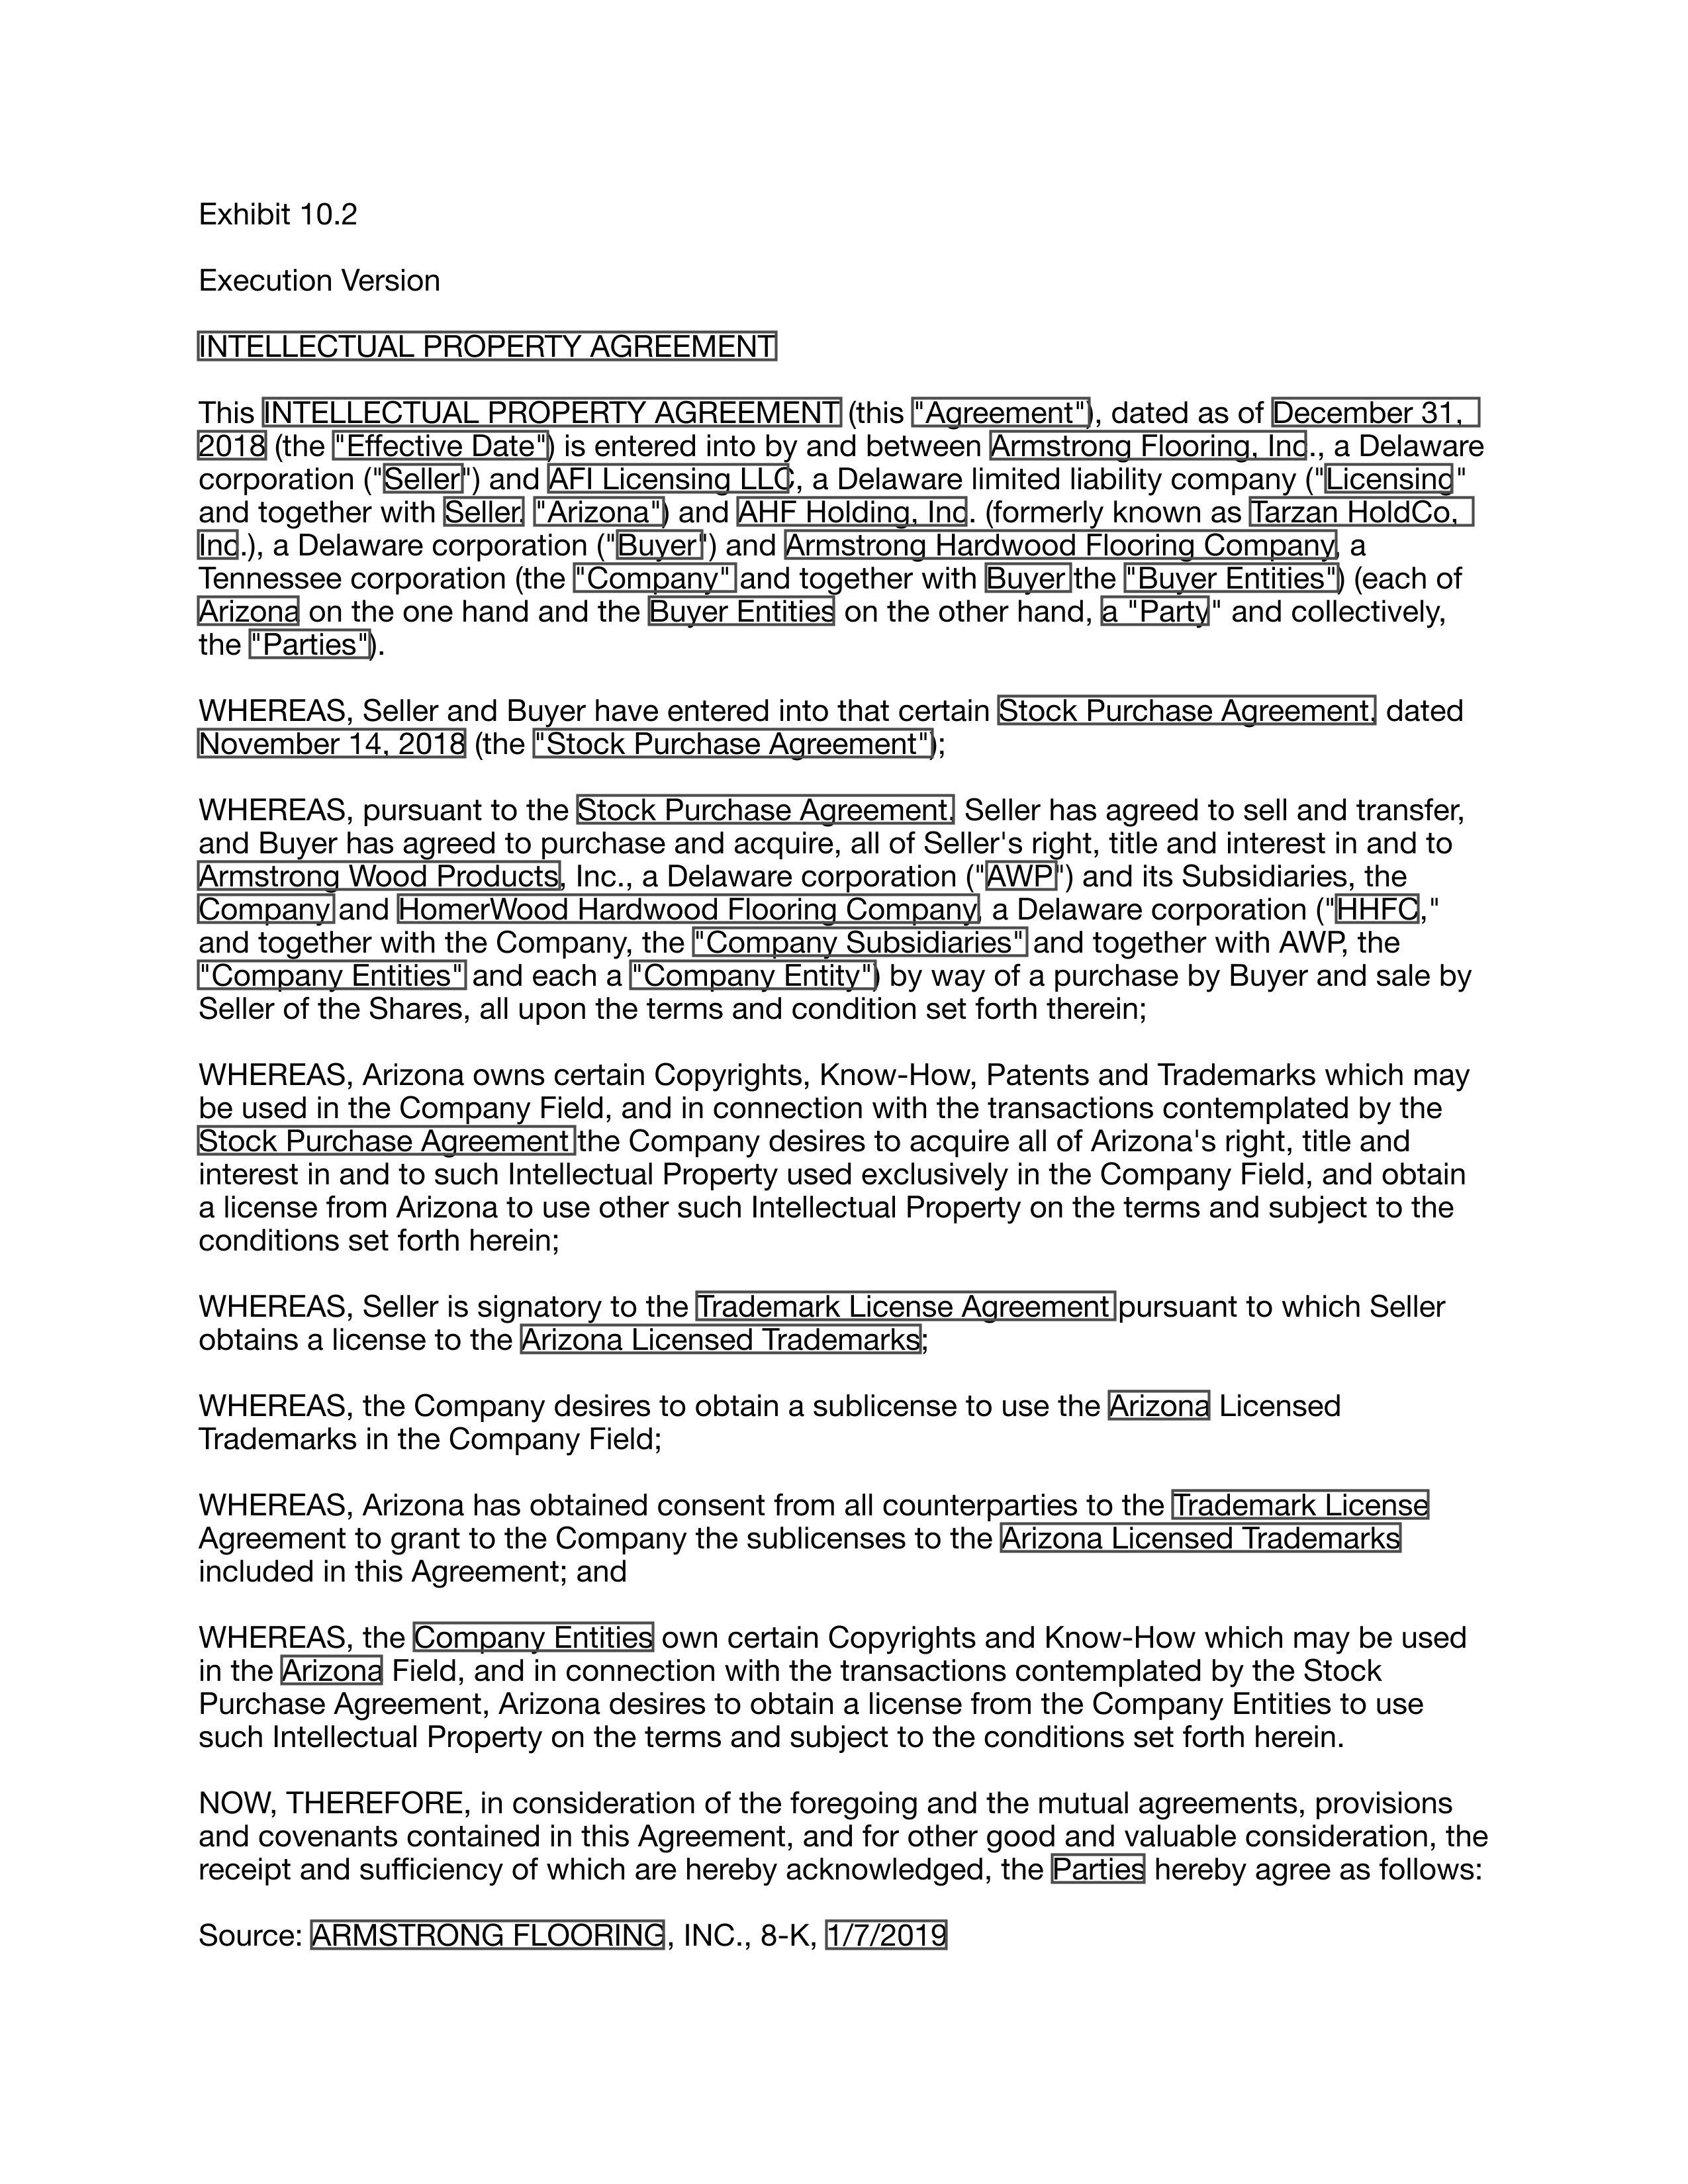

In [18]:
display_pdf(result.select("pdf_with_regions", "path"), field="pdf_with_regions")

In [ ]:
#%%bash
#rm -r -f result.pdf